# Ajuster un modèle en Python - Méthode des moindres carrés


**Auteurs: Rodolphe Vuilleumier, Serge Stinckwich**


Nous allons utiliser dans cette fiche les connaissances que vous avez acquises sur les librairies numpy et matplotlib. En suivant la progression proposée, vous devrez construire un code Python fonctionnel intégrant les fonctionnalités demandées. Ce code devra être commenté convenablement. **Vous devrez aussi produire des figures de qualité et ayant tout le contenu (axes, légende... ) qui en font de bonnes figures scientifiques et tel que vous l’avez vu dans la fiche 2.**

La [méthode des moindres carrés](https://fr.wikipedia.org/wiki/Méthode_des_moindres_carrés) est une méthode d'analyse de données. Très souvent, on est amené à comparer des données expérimentales, généralement entachées d'erreurs, avec un modèle mathématique. Ce modèle mathématique est décrit par un ensemble de fonctions $f(x,\theta)$ d'une ou plusieurs variables physique $x$ et dépendant d'un certain nombre de paramètres dénotés $\theta$. La méthode des moindres carrés proposés par le célèbre mathématicien Gauss au début du XIXieme siècle permet de déterminer la valeur de ces paramètres $\theta$ qui permet de reproduire au mieux les données expérimentales.
Nous allons discuter et illustrer cette méthode pour la détermination de la [constante de Hubble](https://fr.wikipedia.org/wiki/Constante_de_Hubble) à partir de données de distance et de vitesse d'éloignement de 17 galaxies.

## Préliminaires
Le fichier [vitesses.txt](https://github.com/SergeStinckwich/ARE-UPMC/blob/master/ARE-DYNAMIC/vitesses.txt) contient les distances en megaparsec et les vitesses d’éloignement en km/s de 17 galaxies (source : Galaxies and Cosmology, Jones and Lambourne, page 243). On va lire ces données grâce à la fonction loadtxt de numpy :

In [1]:
import numpy as np
d,v=np.loadtxt('vitesses.txt',skiprows=2,usecols=(0,1),unpack=True)
d,v

(array([ 0.028,  0.076,  0.108,  0.136,  0.153,  0.226,  0.283,  0.359,
         0.363,  0.408,  0.438,  0.472,  0.476,  0.476,  0.493,  0.556,
         0.639]),
 array([  2.7,   4.2,  10.5,  14.1,  10.5,  13.2,  19.8,  28.2,  20.7,
         29.4,  31.8,  44.4,  32.1,  37.2,  33. ,  34.5,  46.5]))

Le tableau ```d``` contient alors les distances en megaparsec et le tableau ```v``` les vitesses d’éloignement en km/s. Tracons les vitesses d’éloignement en fonction des distances :

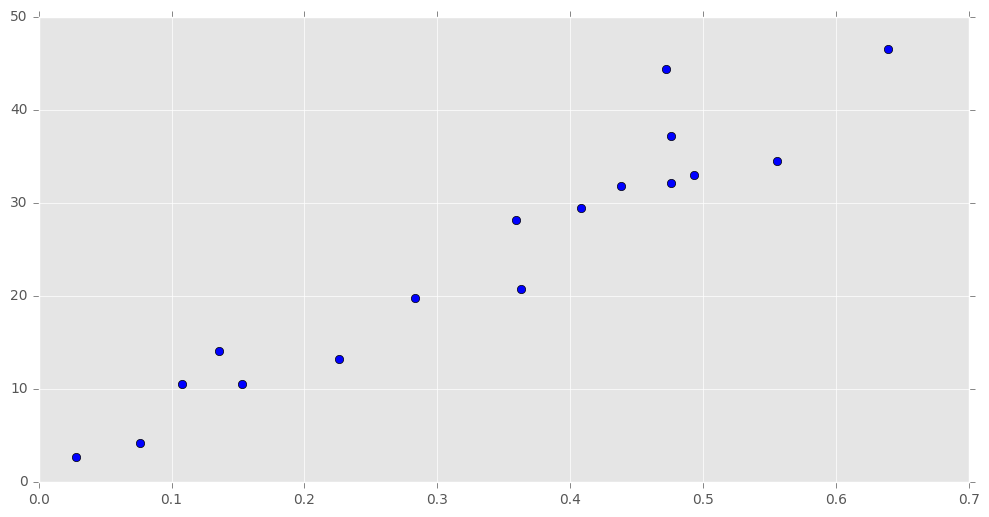

In [2]:
%matplotlib inline
from pylab import *
matplotlib.style.use('ggplot')
figure(figsize=(12,6), dpi=80)
plot(d, v, 'bo')
show()

Si on relit les points entre eux:

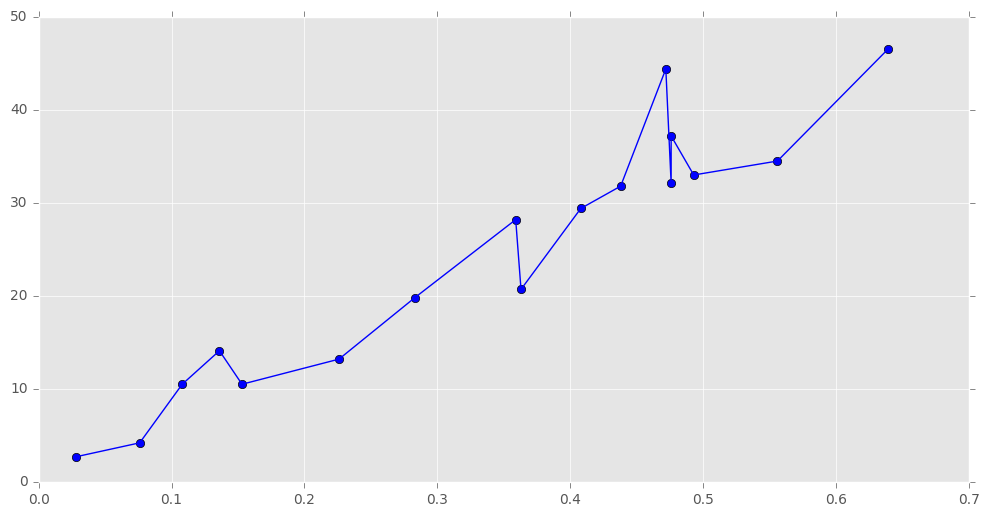

In [3]:
%matplotlib inline
from pylab import *
figure(figsize=(12,6), dpi=80)
plot(d, v, 'bo')
plot(d, v, 'b-')
show()

On s'aperçoit que les vitesses d'éloignement croissent avec la distance. [Hubble](https://en.wikipedia.org/wiki/Edwin_Hubble) en 1929 a proposé que la vitesse d'éloignement d'une galaxie est proportionnelle à sa distance à la Terre :
$$
v=H_0d,
$$

où il a introduit la constante $H_0$ de proportionnalité, depuis appelée constante de Hubble. Cette loi décrit l'expansion de l'univers depuis le big-bang. Nous allons déterminer $H_0$ à partir de ces données, puis en déduire une estimation de l'âge de l'univers.

Nous allons tout d'abord tenter de déterminer $H_0$ de manière empirique.
Ecrivons la fonction ```model(d,H0)``` :

In [4]:
def model(d, H0):
    return d*H0

qui prend en entrée le tableau d des distances et une valeur ```H0``` et renvoie un tableau des vitesses d'éloignement du modèle avec une valeur d'essai ```H0``` de la constante $H_0$.

Si on applique la fonction ```model```avec une valeur spécifique de ```H0``` sur le tableau ```d```des valeurs expérimentales, on obtient un tableau ```v``` des vitesses que l'on devrait observer. Par exemple avec $H_0=40$, on obtient :

In [5]:
model(d,40)

array([  1.12,   3.04,   4.32,   5.44,   6.12,   9.04,  11.32,  14.36,
        14.52,  16.32,  17.52,  18.88,  19.04,  19.04,  19.72,  22.24,
        25.56])

Traçons ensemble les données expérimentales et les données modèles pour quelques valeurs d'essai de $H_0$.

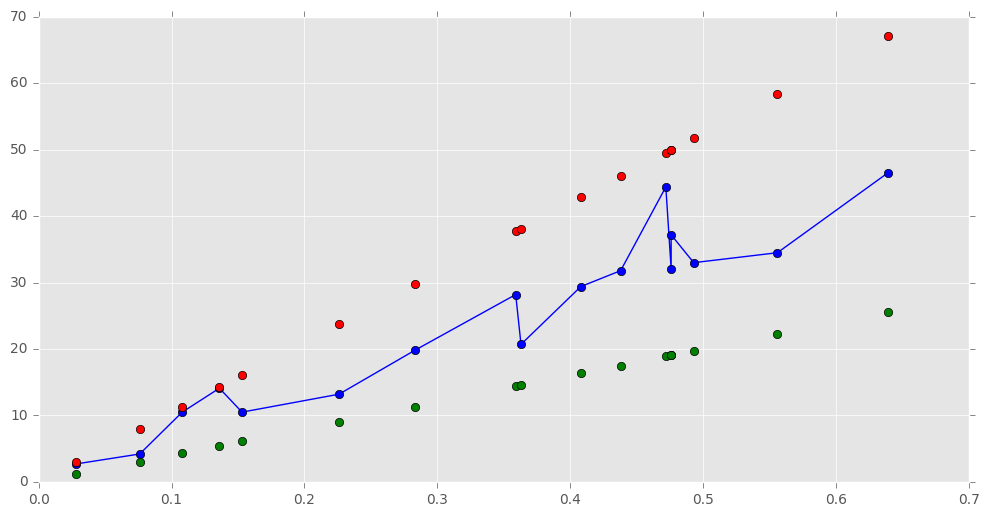

In [9]:
figure(figsize=(12,6), dpi=80)
plot(d, v, 'b-')
plot(d, v, 'bo')
plot(d, model(d, 40), 'go')
plot(d, model(d, 105), 'ro')
show()

On peut déjà conclure que $H_0$ est entre 40 et 105. Chercher la valeur qui vous semble le mieux reproduire les données expérimentales. Comparer votre estimation de $H_0$ avec celles de vos voisins.

Pour déterminer $H_0$ de façon systématique nous allons maintenant utiliser la méthode des moindres carrés.

## Méthode des moindres carrés ordinaire

On suppose d'une manière générale que l'on a un jeu de données $(x_i,y_i)$, $i=1,\ldots,N$, et un modèle $f(x,\theta)$ de la valeur de $y$ à $x$ donné, paramétré par un jeu de paramètres $\theta$. Pour déterminer les meilleurs paramètres $\theta$ on se propose dans la méthode des moindres carrés de minimiser une distance entre les valeurs modèles et les valeurs observées. On définit cette distance par :

$$
\chi^2(\theta)=\sum_{i=1}^N\left(y_i-f(x_i,\theta)\right)^2=\sum_{i=1}^N r_i(\theta)^2,
$$

où dans la deuxième équation on a définit les résidus $r_i(\theta)$ pour $i=1,\ldots,N$ par

$$
r_i(\theta)=y_i-f(x_i,\theta).
$$

La méthode des moindres carrés consiste alors simplement à minimiser cette quantité en fonction de $\theta$ pour un jeu de valeurs expérimentales $(x_i,y_i)$, $i=1,\ldots,N$ données.


Dans un premier temps, écrire une fonction ```residus(d, v, H0)```

```python
def residus(d, v, H0):
```
qui prend en entrée les tableaux de données ```d``` et ```v```, une valeur ```H0``` et renvoie un tableau des résidus, différences entre les valeurs de vitesses observées et les valeurs modèles.

A partir de cette fonction, écrire une autre fonction ```chi2(d, v, H0)```

```python
def chi2(d, v, H0):
```
qui prend en entrée les tableaux de données ```d``` et ```v```, une valeur ```H0``` et renvoie la valeur de la distance $\chi^2$ entre les valeurs observées et le modèle, définie ci-dessus.

Tracer la valeur $\chi^2(H_0)$ pour des valeurs de $H_0$ encadrant la valeur que vous aviez trouvée précédemment. Observer la présence d'un minimum. Estimer la valeur de $H_0$ au minimum.

Ecrire une fonction ```minimise(d, v, min, max, precision)```

```python
def minimise(d, v, min, max, precision):
```

qui prend en entrée les tableaux ```d``` et ```v```, un intervalle ```min``` et ```max```définissant un intervalle de recherche de $H_0$ et enfin une précision ```precision```. La fonction retourne la valeur de $H_0$, avec une précision donnée, qui minimise $\chi^2(H_0)$.

Utiliser cette fonction pour déterminer la valeur de la constante de Hubble à $0.01$ près selon la méthode des moindres carrés.

### Evaluation de la qualité de l'ajustement
La précision discutée ci-dessous est la précision sur l'étape de minimisation mais ne représente pas l'erreur potentiellement commise sur la valeur optimale de $H_0$ qui dépend, entre autre, du nombre de données et de l'erreur expérimentale entachant ces données. Il est aussi possible que le modèle que l'on teste ne soit pas correct. Nous allons donc maintenant nous intéresser à la qualité de l'ajustement de $H_0$.

Tracer les résidus $r_i(H_{0,opt})$ en fonction des distances $d_i$ pour la valeur optimale de $H_0$.

On peut remarquer que l'amplitude de variation des erreurs résiduelles (i.e. résidus) du modèle optimal est plus petite que l'amplitude de variation pour un $H_0$ non optimal. Ces deux quantités sont caractérisées par

$$
S_{signal}=\sum_{i=1}^N(y_i-\bar{y})^2,
$$

où $\bar{y}$ est la moyenne des observations, $\bar{y}=\dfrac{1}{N}\sum_{i=1}^N y_i$, et 

$$
S_{residus}=\sum_{i=1}^N(y_i-f(x_i,H_{0}))^2.
$$

Plus le rapport $\dfrac{S_{residus}}{S_{signal}}$ est petit plus l'ajustement est bon. Il est conventionnel de définir le paramètre $R^2$ par

$$
R^2=1-\dfrac{S_{residus}}{S_{signal}}.
$$

Plus $R^2$ est proche de 1, plus l'ajustement est bon. Conventionnellement, on considère qu'il faut $R^2>0.85$.

Ecrire une fonction ```R2(d,v,H0)``` :

```python
def R2(d,v,H0):
```

qui prend en entrée les tableaux de données ```d``` et ```v```, une valeur ```H0``` et renvoie pour cette valeur de $H_0$ le paramètre $R^2$ défini ci-dessus.

### Figures

Illustrer ce que l'on vient de voir par trois figures :

- Une figure montrant $\chi^2(H_0)$ en fonction de $H_0$ sur une plage encadrant la valeur optimale de $H_0$. Indiquer sur cette figure la position de la valeur optimale et la valeur de $\chi^2$ en ce point.
- Une figure montrant les données expérimentales et le modèle optimal. Rappeler l'équation du modèle optimale et la valeur de $R^2$ sur la figure.
- Une figure montrant les résidus du modèle optimal.

## Méthodes des moindres carrés avec poids

En observant la figure donnant les résidus en fonction de la distance on s'aperçoit que l'erreur augmente avec la distance, ce qui n'est pas surprenant. Cependant, on peut se demander si la distance du modèle à ces points doit être considérée comme la distance aux points où l'erreur est plus faible. On appelle $\sigma_i$ l'erreur estimée pour le point $i$, dans la méthodes des moindres carrés avec poids, on définit alors la distance du modèle aux données expérimentales par

$$
\chi_w^2(\theta)=\sum_{i=1}^N\left(\frac{y_i-f(x_i,\theta)}{\sigma_i}\right)^2.
$$

On supposera ici que les erreurs $\sigma_i$ sont proportionnelles à la distance $\sigma_i\propto d_i$ et on posera

$$
\chi_w^2(H_0)=\sum_{i=1}^N\left(\frac{v_i-H_0d_i}{d_i}\right)^2=\sum_{i=1}^N\left(\frac{v_i}{d_i}-H_0\right)^2.
$$

Ecrire une fonction ```chi2weighted(d,v,H0)```
```python
def chi2weighted(d,v,H0):
```

qui prend en entrée les tableaux de données ```d``` et ```v```, une valeur ```H0``` et renvoie la valeur de la distance pondérée $\chi_w^2$ entre les valeurs observées et le modèle, définie ci-dessus.

Généraliser la fonction ```minimise``` définie précédemment pour passer en paramètre la fonction à minimiser.

En déduire alors la nouvelle valeur optimale de la constante de Hubble par la méthode des moindres carrés avec poids. 

Ajouter ce modèle sur la figure montrant la comparaison entre les modèles et les données expérimentales.

Le problème présenté ici est très simple, avec **un seul paramètre** ajustable dans le modèle. Dans le cas général, on a plusieurs paramètres ajustables $\theta_1$, $\theta_2 ,\ldots, \theta_M$. Il convient alors de minimiser la distance $\chi^2$, ou $\chi_w^2$ du modèle aux données expérimentales, par rapport aux $M$ paramètre du modèle. I faudra alors utiliser une routine de minisation pour un nombre quelconque de variables. Cependant, dans un certain nombre de cas, comme pour un modèle linéaire, la solution à ce problème de minimisation est analytique.

## Estimation de l'âge de l'univers

En supposant que la vitesse d'éloignement des galaxies est constante au cours du temps, on peut écrire

$$
d = vt
$$

où $t$ est le temps depuis le big-bang, correspondant à $d=0$, c'est-à-dire l'âge de l'univers. Si on injecte la loi d'expansion de Hubble dans cette formule, on obtient

$$
d=H_0 d t
$$

soit

$$
1=H_0  t
$$

et on a alors l'âge de l'univers qui dans cette hypothèse est donné par $t=\dfrac{1}{H_0}$.

Estimer en milliards d'années, l'âge de l'univers en utilisant les deux valeurs estimées de $H_0$ par la méthode des moindres carrés et la méthode des moindres carrés avec poids.

En fait, dans le cadre des théories cosmologiques, cette hypothèse n'est pas en accord avec les données expérimentales et l'âge de l'univers doit alors être re-calculé. On peut écrire la correction à effectuer sous la forme

$$
t=\frac{1}{H_0}F.
$$

La valeur du facteur de correction $F$ dérivant des observations du satellite Planck est $F=0.956$. Bien qu'il soit proche de $1$ ce facteur cache des périodes d'accélération (big-bang) et de décélération de l'expansion de l'univers.

## Utilisation de la bibliothèque leastsq de SciPy

Au lieu de définir notre fonction pour appliquer la méthode des mondres carrés, nous pouvons utiliser celle fournit en standard par Python dans SciPy : https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html

In [7]:
import numpy
import matplotlib.pyplot as plt

d = numpy.array([0.028,0.076,0.108,0.136,0.153,0.226,0.283,0.359,0.363,0.408,0.438,0.472,0.476,0.476,0.493,0.556,0.639])
v = numpy.array([2.7,4.2,10.5,14.1,10.5,13.2,19.8,28.2,20.7,29.4,31.8,44.4,32.1,37.2,33,34.5,46.5])

def model(H0, d):
    return(d*H0)

def residus(H0, d, v):
    return(v-model(H0,d))

from scipy.optimize import leastsq

x0 = numpy.zeros(1)
result = leastsq(residus, x0, args=(d, v))

print(result[0])

[ 72.06013499]
